In [1]:
import os
import re
import glob
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as sk_io
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from cvutils.mrcnn.session import init_keras_session
from celldom import seed
import keras
from keras.preprocessing import image

init_keras_session()

DATA_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'DigitTraining', 'single')
MODEL_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'digit_model', 'head')
model_path = osp.join(MODEL_DIR, 'single_digit_model.h5')

MODEL_DIR_TUNE = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'digit_model', 'tune')
model_path_tune = osp.join(MODEL_DIR_TUNE, 'single_digit_model.h5')

DATA_DIR, MODEL_DIR

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


('/lab/data/celldom/dataset/dataset03/DigitTraining/single',
 '/lab/data/celldom/model/r0.2/digit_model/head')

In [2]:
!ls $DATA_DIR | head -n 1

BF_ST_000_APT_000Day0-APT-0-0.jpeg
ls: write error: Broken pipe


In [3]:
def get_actual_digit(file):
    return osp.basename(file).replace('.jpeg', '').split('-')[-1]

def load_images():
    res = []
    for f in glob.glob(osp.join(DATA_DIR, '*.jpeg')):
        digit = get_actual_digit(f)
        img = sk_io.imread(osp.join(DATA_DIR, f))
        res.append((digit, img))
    res = pd.DataFrame(res, columns=['digit', 'img'])
    res['digit'] = res['digit'].astype(int)
    return res

In [4]:
df = load_images()

In [5]:
len(df)

2372

In [6]:
df['digit'].value_counts()

0    1126
1     391
2     130
4     116
3     112
6     112
8     107
9      97
7      94
5      87
Name: digit, dtype: int64

In [7]:
dtypes = df['img'].apply(lambda v: v.dtype)
assert np.all(dtypes == np.uint8)
dtypes.value_counts()

uint8    2372
Name: img, dtype: int64

In [8]:
pd.DataFrame([r['img'].shape for _, r in df.iterrows()]).describe()

,0,1
count,2372.000000,2372.000000
mean,53.712479,38.337690
std,3.704381,5.382952
min,31.000000,17.000000
25%,53.000000,35.000000
50%,55.000000,41.000000
75%,56.000000,42.000000
max,58.000000,49.000000


In [9]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(df))
idx_train, idx_test = train_test_split(idx, test_size=.33, random_state=seed, stratify=df['digit'])
df_train, df_test = df.iloc[idx_train], df.iloc[idx_test]
len(df_train), len(df_test)

(1589, 783)

In [10]:
pd.concat([df_train['digit'].value_counts(normalize=True), df_test['digit'].value_counts(normalize=True)], axis=1)

,digit,digit
0,0.474512,0.475096
1,0.164884,0.164751
2,0.054751,0.054917
4,0.049087,0.048531
6,0.047199,0.047254
3,0.047199,0.047254
8,0.045312,0.044700
9,0.040906,0.040868
7,0.039648,0.039591
5,0.036501,0.037037


## Training

In [11]:
%run utils.py

In [12]:
target_shape = (32, 32)

In [13]:
model = get_digit_model(input_shape=target_shape + (3,), mode='head')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.001),
    metrics=['accuracy']
)

In [14]:
model.load_weights('/lab/repos/svhn/weights.hdf5')

In [15]:
from imgaug import augmenters as iaa
from skimage import img_as_ubyte, img_as_float32

sometimes = lambda aug: iaa.Sometimes(.3, aug)
seq = iaa.Sequential([
    # Simulate out-of-focus
    sometimes(iaa.GaussianBlur(sigma=1.5)),
    
    # Randomly alter scaling and simulate zooming
    sometimes(iaa.Crop(5)),
    
    # Rotate up to 5 degrees
    sometimes(iaa.Affine(rotate=3., scale={"x": (1., 1.5), "y": (1., 1.5)}, mode='reflect')),
    
    # Randomly alter distribution
    sometimes(iaa.OneOf([iaa.Multiply((.8, 1.4)), iaa.Add((-25, 25))])),
], random_order=True)

def augment(img):
    # img should be provided as float in [0, 1]
    assert img.min() >= 0 and img.max() <= 1.
    img = rescale_intensity(img, out_range=np.uint8).astype(np.uint8)
    res = img_as_float32(seq.augment_image(img))
    #print(res.shape, res.dtype, res.min(), res.max())
    return res

In [16]:
def prep_image(img):
    # Note that gray2rgb will take care of converting from uint8 to float in 0-1
    assert img.dtype == np.uint8
    img = gray2rgb(resize(img, target_shape, mode='constant', anti_aliasing=True)).astype(np.float32)
    assert np.all(img <= 1.) and np.all(img >= 0.)
    return img

train_x = np.stack([prep_image(v) for v in df_train['img']], 0)
train_y = keras.utils.to_categorical(df_train['digit'].values, 10)

test_x = np.stack([prep_image(v) for v in df_test['img']], 0)
test_y = keras.utils.to_categorical(df_test['digit'].values, 10)

# train_generator = image.ImageDataGenerator(
#     rotation_range=5, zoom_range=.2, width_shift_range=.05,
#     height_shift_range=.05, brightness_range=(.6, 1.)
# )
train_generator = image.ImageDataGenerator(preprocessing_function=augment)
#train_batches = train_generator.flow(train_x, y=train_y, seed=seed, save_to_dir='/tmp/train_images')
train_batches = train_generator.flow(train_x, y=train_y, seed=seed)

test_generator = image.ImageDataGenerator()
test_batches = test_generator.flow(test_x, y=test_y, seed=seed)

train_x.dtype, train_x.shape, test_x.shape

(dtype('float32'), (1589, 32, 32, 3), (783, 32, 32, 3))

In [17]:
# Clear everything currently in the modeling directory
!rm $MODEL_DIR/*
!rm /tmp/train_images/*

/bin/sh: 1: rm: Argument list too long


In [18]:
save_model = keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc', mode='max', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='max')
tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
callbacks = [save_model, early_stopping, tensorboard]
#callbacks = [save_model, tensorboard]

model.fit_generator(
    train_batches, 
    epochs=50,
    callbacks=callbacks,
    validation_data=test_batches
)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/50
50/50 [==============================] - 4s 84ms/step - loss: 0.3919 - acc: 0.8846 - val_loss: 0.0488 - val_acc: 0.9885
Epoch 2/50
50/50 [==============================] - 3s 56ms/step - loss: 0.1142 - acc: 0.9665 - val_loss: 0.0260 - val_acc: 0.9949
Epoch 3/50
50/50 [==============================] - 3s 65ms/step - loss: 0.0953 - acc: 0.9709 - val_loss: 0.0237 - val_acc: 0.9936
Epoch 4/50
50/50 [==============================] - 3s 64ms/step - loss: 0.0565 - acc: 0.9841 - val_loss: 0.0191 - val_acc: 0.9949
Epoch 5/50
50/50 [==============================] - 3s 57ms/step - loss: 0.0412 - acc: 0.9856 - val_loss: 0.0180 - val_acc: 0.9949
Epoch 6/50
50/50 [==============================] - 3s 65ms/step - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0183 - val_acc: 0.9949
Epoch 7/50
50/50 [==============================] - 3s 68ms/step - loss: 0.0324 - acc: 0.9875 - val_loss: 0.0185 - val_acc: 0.9949
Epoch 8/50

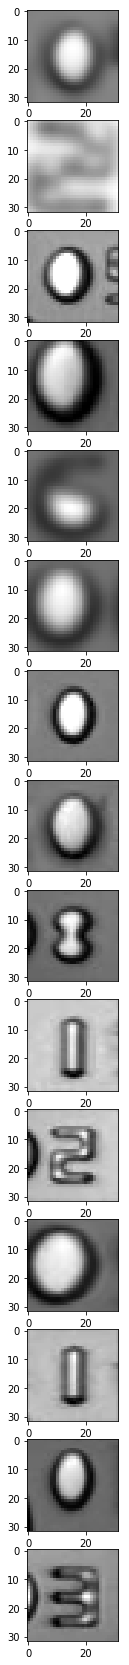

In [51]:
tfiles = os.listdir('/tmp/train_images')
np.random.shuffle(tfiles)
fig, ax = plt.subplots(15, 1)
fig.set_size_inches(4, 15*2)
for i in range(15):
    ax[i].imshow(sk_io.imread('/tmp/train_images/' + tfiles[i]))
    

In [19]:
# Fine-tuning
!rm $MODEL_DIR_TUNE/*

model = get_digit_model(input_shape=target_shape + (3,), mode='tune')
model.load_weights(model_path)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.001),
    metrics=['accuracy']
)

save_model = keras.callbacks.ModelCheckpoint(model_path_tune, monitor='val_acc', mode='max', verbose=1,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='max')
tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR_TUNE)
callbacks = [save_model, early_stopping, tensorboard]
model.fit_generator(
    train_batches, 
    epochs=30,
    callbacks=callbacks,
    validation_data=test_batches
)

Epoch 1/30
50/50 [==============================] - 3s 67ms/step - loss: 0.0167 - acc: 0.9937 - val_loss: 0.0198 - val_acc: 0.9962

Epoch 00001: val_acc improved from -inf to 0.99617, saving model to /lab/data/celldom/model/r0.2/digit_model/tune/single_digit_model.h5
Epoch 2/30
50/50 [==============================] - 3s 53ms/step - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0228 - val_acc: 0.9962

Epoch 00002: val_acc did not improve from 0.99617
Epoch 3/30
50/50 [==============================] - 3s 65ms/step - loss: 0.0137 - acc: 0.9969 - val_loss: 0.0238 - val_acc: 0.9974

Epoch 00003: val_acc improved from 0.99617 to 0.99745, saving model to /lab/data/celldom/model/r0.2/digit_model/tune/single_digit_model.h5
Epoch 4/30
50/50 [==============================] - 3s 63ms/step - loss: 0.0135 - acc: 0.9987 - val_loss: 0.0236 - val_acc: 0.9974

Epoch 00004: val_acc did not improve from 0.99745
Epoch 5/30
50/50 [==============================] - 3s 69ms/step - loss: 0.0062 - acc: 0.9975 - v

## Inference

In [20]:
model = keras.models.load_model(model_path_tune)

In [21]:
inf_x, inf_y = test_x, test_y
inf_y = np.argmax(inf_y, axis=1)
inf_x.shape, inf_y.shape

((783, 32, 32, 3), (783,))

In [22]:
inf_y_pred = model.predict_classes(inf_x)
inf_y_pred.shape

(783,)

In [23]:
# Overall accuracy
(inf_y_pred == inf_y).mean()

0.9987228607918263

In [24]:
pd.DataFrame(dict(pred=inf_y_pred, true=inf_y)).groupby(['pred', 'true']).size().unstack().fillna(0)\
    .style.background_gradient(high=.7)

true,0,1,2,3,4,5,6,7,8,9
pred,,,,,,,,,,
0,372,0,0,0,0,0,0,0,0,0
1,0,129,0,0,0,0,0,0,0,0
2,0,0,42,0,0,0,0,0,0,0
3,0,0,0,37,0,0,0,0,0,0
4,0,0,0,0,38,0,0,0,0,0
5,0,0,1,0,0,29,0,0,0,0
6,0,0,0,0,0,0,37,0,0,0
7,0,0,0,0,0,0,0,31,0,0
8,0,0,0,0,0,0,0,0,35,0


#### Show Misclassified Instances

In [25]:
misclassified = np.argwhere(inf_y_pred != inf_y).ravel()

In [26]:
len(misclassified)

1

In [27]:
misclassified

array([112])

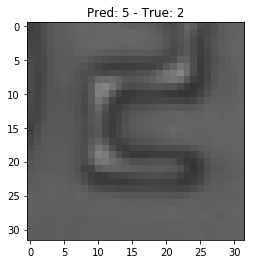

In [28]:
#n_samp = 10
#indexes = pd.Series(list(range(len(pred_y_class)))).sample(n_samp)

n_samp = len(misclassified)
indexes = misclassified

fig, ax = plt.subplots(n_samp, 1)
if n_samp == 1:
    ax = [ax]
fig.set_size_inches(4, n_samp * 4)
for i, idx in enumerate(indexes):
    ax[i].imshow(inf_x[idx])
    ax[i].set_title('Pred: {} - True: {}'.format(inf_y_pred[idx], inf_y[idx]))